# ADM - HW5 - The Marvel Universe!

## Libraries & Setup

In [3]:
import networkx as nx   # Network analysis

import pandas as pd   # Data manipulation and analysis
import numpy as np    # Scientific Computing

import matplotlib.pyplot as plt   # Visualization

import warnings
warnings.filterwarnings('ignore')

#import functions

# 1. Data

## Data Preprocessing

In [4]:
nodes_df = pd.read_csv("nodes.csv")
edges_df = pd.read_csv("edges.csv")
hero_network_df = pd.read_csv("hero-network.csv")

In [4]:
nodes_df

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


In [5]:
edges_df

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [6]:
hero_network_df

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE /
574464,CALLISTO,CALIBAN/
574465,CALIBAN/,ROGUE /


For the data to be *consistent* across all the dataframes, **all hero names** appearing in the *hero_network* dataframe should **also be found** in the *edges* dataframe

In [6]:
# Retrieve heroes' names appearing in "hero_network" dataframe, but not in "edges" dataframe
def check_inconsistency():
    names = set(hero_network_df.hero1).union(set(hero_network_df.hero2)).difference(set(edges_df.hero))
    out = names if len(names)!=0 else "No inconsistencies found!"
    return out

In [4]:
# Some inconsistency examples
list(check_inconsistency())[:10]

['KLIGGER/SEN. EUGENE ',
 'MAN-SPIDER | MUTANT ',
 'SHADOWCAT/KATHERINE ',
 'MANIKIN/DR. WHITMAN ',
 'FURY, COL. NICHOLAS ',
 'MODULAR MAN/STEPHEN ',
 'SCARLET WITCH/WANDA ',
 'ROOSEVELT, FRANKLIN ',
 'MAGNETO/MAGNUS/ERIC ',
 'MARTINELLI, VINCENT ']

**Inconsistency reason 1:** some heroes' names in the *hero_network* dataframe have **extra spaces** at the end of their names

In [7]:
hero_network_df.hero1 = [x.strip() for x in hero_network_df.hero1]
hero_network_df.hero2 = [x.strip() for x in hero_network_df.hero2]

In [6]:
check_inconsistency()

{'BLADE', 'SABRE', 'SPIDER-MAN/PETER PAR'}

**Inconsistency reason 2:** some heroes in the *hero_network* dataframe **are missing a "/"** at the end of their names. In fact, *BLADE* and *SABRE* are labelled as **comics** in the *nodes* dataframe, while *BLADE/* and *SABRE/* represent the actual **heroes**

In [8]:
hero_network_df.loc[hero_network_df["hero1"] == "BLADE", "hero1"] = "BLADE/"
hero_network_df.loc[hero_network_df["hero2"] == "BLADE", "hero2"] = "BLADE/"
hero_network_df.loc[hero_network_df["hero1"] == "SABRE", "hero1"] = "SABRE/"
hero_network_df.loc[hero_network_df["hero2"] == "SABRE", "hero2"] = "SABRE/"

In [8]:
check_inconsistency()

{'SPIDER-MAN/PETER PAR'}

**Inconsistency reason 3:** the hero name *"SPIDER-MAN/PETER PARKER"* in the *edges* dataframe has been changed to *"SPIDER-MAN/PETER PAR"* the *hero_network* dataframe

In [9]:
hero_network_df.loc[hero_network_df["hero1"] == "SPIDER-MAN/PETER PAR", "hero1"] = "SPIDER-MAN/PETER PARKER"
hero_network_df.loc[hero_network_df["hero2"] == "SPIDER-MAN/PETER PAR", "hero2"] = "SPIDER-MAN/PETER PARKER"

In [10]:
check_inconsistency()

'No inconsistencies found!'

We also remove entries of the *hero_network* dataframe having the same hero in **both columns** (in order to avoid **self-loops** in the graph)

In [9]:
# With self-loop records
len(hero_network_df)

574467

In [11]:
hero_network_df.drop(hero_network_df[hero_network_df['hero1'] == hero_network_df['hero2']].index, inplace = True)

In [11]:
# Without self-loop records
len(hero_network_df)

572235

Finally, we identify and correct the **spelling mistake** in the hero name *"SPIDER-MAN/PETER PARKER"* present in the *nodes* dataframe (listed as *"SPIDER-MAN/PETER PARKERKER"*)

In [12]:
nodes_df.loc[nodes_df["node"] == "SPIDER-MAN/PETER PARKERKER", "node"] = "SPIDER-MAN/PETER PARKER"

## Graphs setup

### First graph: G1 - Heroes appearing in the same comic together

The graph **G1** should be **undirected** and **weighted**.

* **Nodes**: *heroes*

* **Edge** between node *Hero_A* and *Hero_B*: the heroes have appeared in the same comic together

* **Edge weight**: the *reciprocal* of the *number of collaborations* of the two heroes

$$w((Hero\_A, Hero\_B)) = \frac{1}{num\_collaborations \; of \; Hero\_A \; and \; Hero\_B}$$

In [10]:
# NetworkX Graph: base undirected graph
G1 = nx.Graph()

In [14]:
# Sort the pair of heroes in each record (since the graph is undirected, we are interested in grouping together pair of names, irrespectively of their order)
hero_network_df[["hero1", "hero2"]] = np.sort(hero_network_df[["hero1", "hero2"]], axis=1)

# Group by pair of names and retrieve group size
heroes_pairs = (hero_network_df.groupby(["hero1", "hero2"]).size().reset_index().values.tolist())

In [15]:
# Some pair of heroes and their number of collaborations
heroes_pairs[:10]

[['24-HOUR MAN/EMMANUEL', 'FROST, CARMILLA', 1],
 ['24-HOUR MAN/EMMANUEL', "G'RATH", 1],
 ['24-HOUR MAN/EMMANUEL', 'KILLRAVEN/JONATHAN R', 1],
 ['24-HOUR MAN/EMMANUEL', "M'SHULLA", 1],
 ['24-HOUR MAN/EMMANUEL', 'OLD SKULL', 1],
 ['3-D MAN/CHARLES CHAN', 'AJAK/TECUMOTZIN [ETE', 1],
 ['3-D MAN/CHARLES CHAN', 'ANGEL/WARREN KENNETH', 1],
 ['3-D MAN/CHARLES CHAN', 'ANT-MAN II/SCOTT HAR', 1],
 ['3-D MAN/CHARLES CHAN', 'ANT-MAN/DR. HENRY J.', 2],
 ['3-D MAN/CHARLES CHAN', 'ARABIAN KNIGHT/ABDUL', 1]]

In [12]:
# Build weighted edges
heroes_collaboration = []

for x in heroes_pairs:
        heroes_collaboration.append(tuple([x[0], x[1], round(1/x[2], 4)]))

In [17]:
# Add edges to graph
G1.add_weighted_edges_from(heroes_collaboration)

### Second graph: G2 - Hero appearing in a specific comic

The graph **G2** should be **undirected** and **unweighted**.

* **Nodes**: *heroes* and *comics*

* **Edge** between node *Hero_A* and *Comic_A*: the hero has appeared in that specific comic

In [20]:
# NetworkX Graph: base undirected graph
G2 = nx.Graph()

In [21]:
# Add nodes with "type" attribute to graph
G2.add_nodes_from([(x[0], {"type": x[1]}) for x in nodes_df.to_records(index=False)])

In [22]:
# Add edges between heroes and comics to graph
G2.add_edges_from(list(edges_df.to_records(index=False)))

# 2. Backend Implementation

## Functionality 1

In [18]:
# Function that returns a list of top N heroes who have appeared in the most number of comics
def top_n(N = -1):
    # dictionary of the top N heros based on their degree in Graph 2 (number of apparision in comics)
    top_heros = sorted(dict(G2.degree()).items(), key=lambda x:x[1] , reverse = True)[:N]
    top_list  = []
    for hero in top_heros:            # Loop over the top heros
        top_list.append(hero[0])      # Append the hero name
    return top_list


In [20]:
# Function that returns number of nodes for a given graph 
def Number_of_nodes(G, type : int , N = -1 ):
    if type == 1:
        G = G.subgraph(top_n(N))    # Create the subgraph of the top N heros
        return G.number_of_nodes()  # returns the number of nodes
    else:
        G = G.edge_subgraph(G.edges(top_n(N)))  # Create the subgraph that contains the top N heros
        number_of_nodes_comic = G.subgraph(list(edges_df['comic'].values)).number_of_nodes()
        number_of_nodes_hero  = G.subgraph(list(edges_df['hero'].values)).number_of_nodes()
        return number_of_nodes_comic , number_of_nodes_hero

In [110]:
# Function that returns the number of collaborations for Graph 1
def Number_of_collaboration(G , type: int , N = -1 ):
    if type != 1:
        raise Exception("Only valid fot type 1")
    G = G.subgraph(top_n(N)) 
    return G.degree()

In [23]:
# Function that returns the number of hero for a given comic
def Number_of_hero_for_each_comic(G , type: int , N = -1 ):
    if type != 2:
        raise Exception("Only valid for type 2")
    G = G.edge_subgraph(G.edges(top_n(N)))
    comics = list(edges_df['comic'].values)  # list of all the comics
    return G.degree(comics)                  # Degree distibution of each comic ( how many heros appear for a given comic)

In [24]:
# Function that returns the density of a graph
def Density(G, type : int , N = -1):
    if type == 1:
        G = G.subgraph(top_n(N))
    else: 
        G = G.edge_subgraph(G.edges(top_n(N)))
    return nx.density(G)
    

In [26]:
# Function that return the degree distribution of a graph
def degree_distribution(G , type: int , N = -1):
    if type == 1:
        G = G.subgraph(top_n(N))
    else: 
        G = G.edge_subgraph(G.edges(top_n(N)))
    dist  = sorted(( d for n , d in G.degree()), reverse=True)
    return dist

In [27]:
# Function that returns the average degree of a graph
def average_degree(G, type: int , N = -1 ):
    if type == 1:
        G = G.subgraph(top_n(N))
    else: 
        G = G.edge_subgraph(G.edges(top_n(N)))
    avg = np.mean(degree_distribution(G , type , N )) # Compute the mean of the degree of each node
    return avg

In [28]:
# Function that returns the hubs of a graph
def Hubs( G , type: int, N = -1):
    if type == 1:
        G = G.subgraph(top_n(N))
    else: 
        G = G.edge_subgraph(G.edges(top_n(N)))

    dist = degree_distribution(G , type , N )    # degree distribution

    threshold = np.quantile( dist, .95)          # value grater than 95% of all the degree 

    hubs = {}                                    # dictionary of the hubs of the network
    
    for nodes , degree in G.degree():            # loop over the nodes
        if degree >= threshold:                  # check if is greater than the threshold
            hubs[f"{nodes}"] = degree            # Update the hubs dictionary
    return hubs

In [29]:
# Function that return if a Network is sparse or dense
def Sparse_or_dense( G , type : int , N = -1):
    if type == 1:
        G = G.subgraph(top_n(N))
    else: 
        G = G.edge_subgraph(G.edges(top_n(N)))
    threshold = 0.5
    Den = Density( G , type , N)
    if Den < threshold:
        x = ('sparse.')
    else:
        x = ('dense.')
    g = f"The graph is {x}"
    return g

### Functionality 5

In [39]:
def remove_edge(G):
    edge = ()
    G_dict = nx.edge_betweenness_centrality(G)
    sort_dict = sorted(G_dict.items() , key = lambda item : item[1] , reverse = True)
    for key , value in sort_dict:
        edge = key
        break
    return edge

In [46]:
def girvan_newman(G):
    sg = nx.connected_components(G)
    sg_count = nx.number_connected_components(G)
    c = 0
    while sg_count == 1:
        G.remove_edge(remove_edge(G)[0], remove_edge(G)[1])
        sg = nx.connected_components(G)
        sg_count = nx.number_connected_components(G)
        c += 1
        
    return sg , c



In [68]:
def functionality_5(G , type , N = -1 , hero1 , hero2 ):
    G = G.subgraph(top_n(N))
    com , count = girvan_newman(G.copy())

    groups = []

    for i in com:
        groups.append(list(i))
    same_com = False
    for x in groups:
        if hero1 in x and hero2 in x:
            same_com = True
            break
    return groups , count




SyntaxError: non-default argument follows default argument (3376897774.py, line 1)

In [60]:
functionality_5(G1 , type = 1 , N = 4)

([['CAPTAIN AMERICA', 'IRON MAN/TONY STARK', 'THING/BENJAMIN J. GR'],
  ['SPIDER-MAN/PETER PARKER']],
 365)

In [58]:
G1.subgraph(top_n(2)).edges

MultiEdgeView([('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 0), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 1), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 2), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 3), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 4), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 5), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 6), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 7), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 8), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 9), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 10), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 11), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 12), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 13), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 14), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 15), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 16), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 17), ('CAPTAIN AMERICA', 'SPIDER-MAN/PETER PARKER', 18), ('CAPTA

In [24]:
G = G1.subgraph(top_n(10))

In [28]:
list(nx.connected_components(G))

[{'CAPTAIN AMERICA',
  'HULK/DR. ROBERT BRUC',
  'HUMAN TORCH/JOHNNY S',
  'INVISIBLE WOMAN/SUE',
  'IRON MAN/TONY STARK',
  'MR. FANTASTIC/REED R',
  'SPIDER-MAN/PETER PARKER',
  'THING/BENJAMIN J. GR',
  'THOR/DR. DONALD BLAK',
  'WOLVERINE/LOGAN'}]

In [35]:
G_dict = nx.edge_betweenness_centrality(G)
sort_dict = sorted(G_dict.items() , key = lambda item : item[1] , reverse = True)


In [37]:
for key , value in sort_dict:
    print(key)
    print(value)
    break

('THOR/DR. DONALD BLAK', 'WOLVERINE/LOGAN', 0)
0.0007936507936507937


# 3. Frontend Implementation

## Visualization 1 

In [63]:
n = 300
type_1 = 1
type_2 = 2
data = [type_1,n,
        Number_of_nodes(G1, type = 1 , N = n),
        Density(G1 , type = 1 , N = n),
        average_degree(G1, type = 1 , N = n), 
        Sparse_or_dense(G1 , type = 1, N = n)]

data_2 = [type_2, n,
        Number_of_nodes(G2, type = 2 , N = n),
        Density(G2 , type = 1 , N = n),
        average_degree(G2, type = 2 , N = n), 
        Sparse_or_dense(G2 , type = 2, N = n)]

col_names = ["Graph type","N","Number_of_nodes", "Density", "average_degree", "Sparse_or_dense" ]

In [64]:
# Importing PrettyTable class from prettytable library
from prettytable import PrettyTable

# Creating instance of PrettyTable class
my_table = PrettyTable(col_names)

# Creating a list that we want to tabulate
my_table.add_row(data)
my_table.add_row(data_2)


# Printing the tabulated list
print(my_table)

+------------+-----+-----------------+----------------------+--------------------+----------------------+
| Graph type |  N  | Number_of_nodes |       Density        |   average_degree   |   Sparse_or_dense    |
+------------+-----+-----------------+----------------------+--------------------+----------------------+
|     1      | 300 |       288       |  5.3470286488579175  | 1534.5972222222222 | The graph is dense.  |
|     2      | 300 |   (11829, 476)  | 0.013957636566332218 | 9.153514831369362  | The graph is sparse. |
+------------+-----+-----------------+----------------------+--------------------+----------------------+


In [108]:
col_names = ["Graph type","N","HUBS"]

data = [type_1,n,
        list(Hubs(G1, type = 1 , N = n).keys())]



table_hubs = PrettyTable(col_names)

# Creating a list that we want to tabulate
table_hubs.add_row(data)
#table_hubs.add_row(data_2)


# Printing the tabulated list
print(table_hubs)


+------------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Graph type |  N  |                                                                                                                                                                       HUBS                                                                                                                                                                      |
+------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

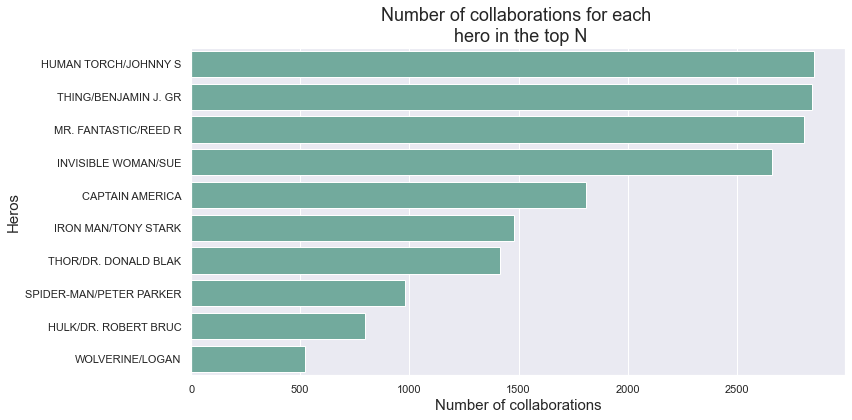

In [140]:
# import libraries
import seaborn as sns
dic= dict(Number_of_collaboration(G1, type = 1 , N = 10))


names = list(dic.keys())
values = list(dic.values())

df = pd.DataFrame({"Hero_names": names,
                "#Collaborations":values})
# set plot style: grey grid in the background:


# load dataset


# Set the figure size
plt.figure(figsize=(12, 6))

# plot a bar chart
sns.barplot(
    x= values, 
    y= names,  
    ci=None, 
    color='#69b3a2',
    order = df.sort_values('#Collaborations', ascending = False).Hero_names);

plt.xlabel("Number of collaborations", size=15)
plt.ylabel("Heros", size=15)
plt.title("Number of collaborations for each \n hero in the top N", size=18)
plt.tight_layout()




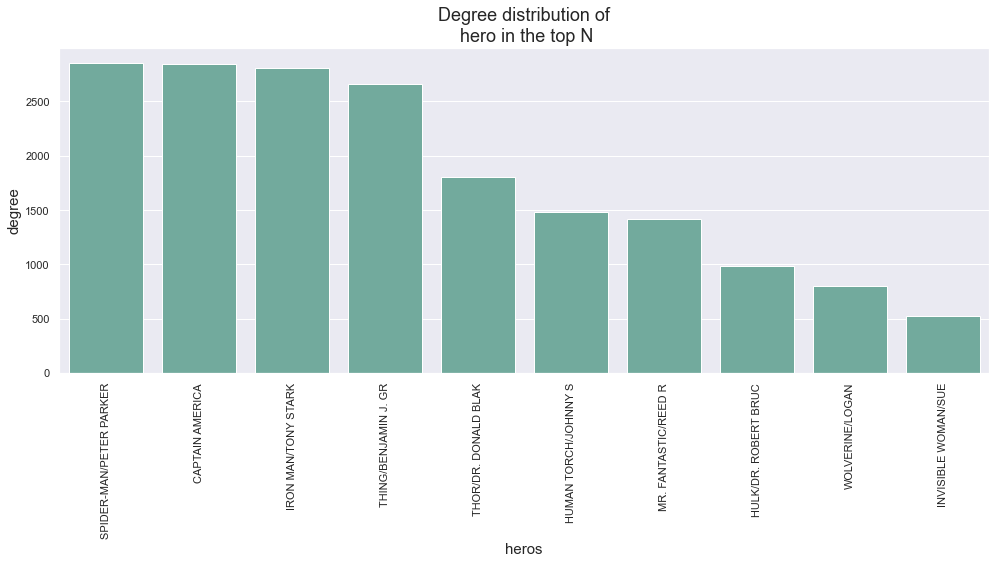

In [141]:
names = top_n(10)
values = degree_distribution(G1 , 1 , 10)
plt.figure(figsize=(14, 8))

# plot a bar chart
sns.barplot(
    y= values, 
    x= names, 
    ci=None, 
    color='#69b3a2');
plt.xticks(rotation=90)
plt.xlabel("heros", size=15)
plt.ylabel("degree", size=15)
plt.title(" Degree distribution of \n hero in the top N", size=18)
plt.tight_layout()

plt.show()
